In [1]:
import xarray as xr

import warnings

import numpy as np

import scipy.stats as stats

from scipy.stats import pearsonr

import pandas as pd

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import glob

import datetime

import matplotlib.pyplot as plt

import pickle

import cartopy.crs as ccrs

from sklearn.preprocessing import QuantileTransformer

import cartopy.feature as cfeature

from scipy.stats import spearmanr

from matplotlib.colors import Normalize

import seaborn as sns

import os

import matplotlib.colors as mcolors

from matplotlib.colors import TwoSlopeNorm

from sklearn.metrics import silhouette_score

from scipy.stats import pearsonr

from pathlib import Path

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

pd.options.mode.chained_assignment = None

### reading in buoyancy arrays

In [2]:
data_dir = Path("/data/rong3/annie/completed_buoyancy_arrays")

blc_files = sorted(glob.glob(str(data_dir / "blc_*.npz")))

blt_files = sorted(glob.glob(str(data_dir / "blt_*.npz")))

def concatenate_arrays(file_list, key):
    
    arrays = [np.load(f)[key] for f in file_list]  # Load arrays using the correct key
    
    return np.concatenate(arrays, axis=0)  # Concatenate along the first dimension

blc_combined = concatenate_arrays(blc_files, key='all_blc')

blt_combined = concatenate_arrays(blt_files, key='all_blt')

blc_combined.shape, blt_combined.shape

((2754, 37, 41), (2754, 37, 41))

### reading in precipitation df

In [3]:
times = pd.date_range("2001-05-01", "2018-09-30", freq="D")

times = times[(times.month >= 5) & (times.month <= 9)]  # Filter months 5-9

times = [d.date() for d in times]  # Convert to datetime.date format


with open('ape_df.pkl', 'rb') as f:
    
    precipdf = pickle.load(f)
    
precipdf = precipdf[precipdf['date'].isin(times)].reset_index(drop=True)

precipdf.shape

(4177818, 6)

### reading in soil moisture

In [4]:
with open('fullsm.pkl', 'rb') as f:
    
    fullsm = pickle.load(f)

In [5]:
fullsm[(fullsm['lat']==36.5) & (fullsm['lon']==-97.5)]['saturation'].value_counts()

saturation
moderate    1946
wet          463
dry          345
Name: count, dtype: int64

In [6]:
fullsm['date'] = pd.to_datetime(fullsm['date'])

precipdf['date'] = pd.to_datetime(precipdf['date'])

master = pd.merge(precipdf, fullsm[['date', 'lat', 'lon', 'saturation']],
                     
                  left_on=['date', 'latitude', 'longitude'],
                     
                  right_on=['date', 'lat', 'lon'],
                     
                  how='inner')  

master.drop(columns=['lat','lon'], inplace=True)

In [7]:
master.shape

(4177818, 7)

In [8]:
check = master[(master['latitude']==36.5) & (master['longitude']==-97.5)]

check['saturation'].value_counts()

saturation
moderate    1946
wet          463
dry          345
Name: count, dtype: int64

### reading in ctp/hilow arrays

In [9]:
ctp_file_path = '/data/rong3/annie/completed_ctp_hilow_arrays/ctp_results.npz'

hi_file_path = '/data/rong3/annie/completed_ctp_hilow_arrays/hi_results.npz'

ctp_data = np.load(ctp_file_path)

hi_data = np.load(hi_file_path)

ctp = ctp_data['ctp_results']

ctp = ctp[0:master['date'].unique().shape[0], :, :]

hi = hi_data['hi_results']

hi = hi[0:master['date'].unique().shape[0], :, :]

### adding ctp & hilow and quality check


In [10]:
ctp_flat = ctp.transpose(1, 2, 0).flatten()

hilow_flat = hi.transpose(1, 2, 0).flatten()

master['ctp'] = ctp_flat

master['hilow'] = hilow_flat

t_idx, lat_idx, lon_idx = 0, 6, 20  

# Ensure to get the correct shape before flattening
timesteps, lat_size, lon_size = ctp.shape

# Compute the expected row in the flattened array
expected_row = (lat_idx * lon_size * timesteps) + (lon_idx * timesteps) + t_idx

print(expected_row)

# Accessing the flattened array correctly
print(f"ctp_flat[{expected_row}] = {ctp_flat[expected_row]}")

print(f"master.iloc[{expected_row}]['ctp'] = {master.iloc[expected_row]['ctp']}")


732564
ctp_flat[732564] = 270.8831889995453
master.iloc[732564]['ctp'] = 270.8831889995453


### adding buoyancy to master and quality check 


In [11]:
blc_combined = blc_combined[0:master['date'].unique().shape[0], :, :]

blt_combined = blt_combined[0:master['date'].unique().shape[0], :, :]

blc_flat = blc_combined.transpose(1, 2, 0).flatten()

blt_flat = blt_combined.transpose(1, 2, 0).flatten()

master['blc'] = blc_flat

master['blt'] = blt_flat

t_idx, lat_idx, lon_idx = 100, 20, 30  

expected_row = (lat_idx * (blc_combined.shape[2] * blc_combined.shape[0])) + (lon_idx * blc_combined.shape[0]) + t_idx

print(expected_row)

print(f"blc_combined[{t_idx}, {lat_idx}, {lon_idx}] = {blc_combined[t_idx, lat_idx, lon_idx]}")

print(f"precipdf.iloc[{expected_row}]['blc'] = {master.iloc[expected_row]['blc']}")

2341000
blc_combined[100, 20, 30] = -108.41521825790467
precipdf.iloc[2341000]['blc'] = -108.41521825790467


### calculating ctp/hilow z scores for every calendar day and every gridpoint 

In [12]:
master['date'] = pd.to_datetime(master['date'])

master['day_month'] = master['date'].dt.strftime('%m-%d')

clim = master.groupby(['latitude', 'longitude', 'day_month'], as_index=False)[['ctp', 'hilow']].agg(['mean', 'std', 'count'])

clim.columns = ['_'.join(col).strip() for col in clim.columns]

clim.rename(columns={"latitude_": "latitude", "longitude_": "longitude", "day_month_": "day_month"}, inplace=True)

master = master.merge(clim, on=["latitude", "longitude", "day_month"], how="left")

master["ctp_stnd_anom"] = (master["ctp"] - master["ctp_mean"]) / master["ctp_std"]

master["hilow_stnd_anom"] = (master["hilow"] - master["hilow_mean"]) / master["hilow_std"]

### below is a test on the quantile transformer

In [33]:
# small = master[(master['latitude']==36.0) & (master['longitude']==-97.5) & (master['day_month']=='05-01')]

# def normal_quantile_transform(group, column):
    
#     transformer = QuantileTransformer(output_distribution='normal', n_quantiles=len(group))  
    
#     group[f'{column}_nqt'] = transformer.fit_transform(group[[column]])  # Apply transform
    
#     return group

# small = small.groupby(['latitude', 'longitude', 'day_month'], group_keys=False).apply(lambda g: normal_quantile_transform(g, 'ctp'))

# small = small.groupby(['latitude', 'longitude', 'day_month'], group_keys=False).apply(lambda g: normal_quantile_transform(g, 'hilow'))

# # Compute standardized anomalies using transformed values

# small["ctp_stnd_anom"] = (small["ctp_nqt"] - small["ctp_nqt"].mean()) / small["ctp_nqt"].std()

# small["hilow_stnd_anom"] = (small["hilow_nqt"] - small["hilow_nqt"].mean()) / small["hilow_nqt"].std()

### normal quantile transform of CTP & hilow

In [34]:
# # quantile transform

# master['date'] = pd.to_datetime(master['date'])

# master['day_month'] = master['date'].dt.strftime('%m-%d')

# def normal_quantile_transform(group, column):
    
#     print(group['latitude'].values[0], group['longitude'].values[0])
    
#     transformer = QuantileTransformer(output_distribution='normal', n_quantiles=len(group))  
    
#     group[f'{column}_nqt'] = transformer.fit_transform(group[[column]])
    
#     return group

# master = master.groupby(['latitude', 'longitude', 'day_month'], group_keys=False).apply(lambda g: normal_quantile_transform(g, 'ctp'))

# master = master.groupby(['latitude', 'longitude', 'day_month'], group_keys=False).apply(lambda g: normal_quantile_transform(g, 'hilow'))

# # Compute standardized anomalies using transformed values

# master["ctp_stnd_anom"] = (master["ctp_nqt"] - master["ctp_nqt"].mean()) / master["ctp_nqt"].std()

# master["hilow_stnd_anom"] = (master["hilow_nqt"] - master["hilow_nqt"].mean()) / master["hilow_nqt"].std()

### calculating buoyancy z scores for every calendar day and every gridpoint 


In [13]:
# precipdf['date'] = pd.to_datetime(precipdf['date'])

master['day_month'] = master['date'].dt.strftime('%m-%d')

clim = master.groupby(['latitude', 'longitude', 'day_month'], as_index=False)[['blc', 'blt']].agg(['mean', 'std', 'count'])

clim.columns = ['_'.join(col).strip() for col in clim.columns]

clim.rename(columns={"latitude_": "latitude", "longitude_": "longitude", "day_month_": "day_month"}, inplace=True)

master = master.merge(clim, on=["latitude", "longitude", "day_month"], how="left")

master["blt_stnd_anom"] = (master["blt"] - master["blt_mean"]) / master["blt_std"]

master["blc_stnd_anom"] = (master["blc"] - master["blc_mean"]) / master["blc_std"]

### defining categories: apes, dry-apes, wet-apes, non-apes

In [14]:
master['dryape'] = (master['APE'] == True) & \
                   (master['ctp_stnd_anom'] > 0) & \
                   (master['saturation'] == 'dry')

master['wetape'] = (master['APE'] == True) & \
                   (master['hilow_stnd_anom'] < 0) & \
                   (master['saturation'] == 'wet')

master['wetcoupling'] = (master['hilow_stnd_anom'] < 0) & \
                   (master['saturation'] == 'wet')

master['drycoupling'] = (master['ctp_stnd_anom'] > 0) & \
                   (master['saturation'] == 'dry')

apes = master[master['APE'] == True].reset_index(drop=True)

dryapes = apes[(apes['ctp_stnd_anom'] > 0) & (apes['saturation'] == 'dry')].reset_index(drop=True)

wetapes = apes[(apes['hilow_stnd_anom'] < 0) & (apes['saturation'] == 'wet')].reset_index(drop=True)

nonapes = master[master['APE'] == False].reset_index(drop=True)

### frequency of dry and wet APEs

In [15]:
dry_counts = master.groupby(['latitude', 'longitude'])['dryape'].sum().reset_index(name='count')

wet_counts = master.groupby(['latitude', 'longitude'])['wetape'].sum().reset_index(name='count')

total_count = len(times)

dry_counts['normalized'] = (dry_counts['count'] / total_count) * 100

wet_counts['normalized'] = (wet_counts['count'] / total_count) * 100

In [16]:
dry_coupling_counts = master.groupby(['latitude', 'longitude'])['drycoupling'].sum().reset_index(name='count')

wet_coupling_counts = master.groupby(['latitude', 'longitude'])['wetcoupling'].sum().reset_index(name='count')

total_count = len(times)

dry_coupling_counts['normalized'] = (dry_coupling_counts['count'] / total_count) * 100

wet_coupling_counts['normalized'] = (wet_coupling_counts['count'] / total_count) * 100

In [17]:
print("dry coupling frequency:", dry_coupling_counts[(dry_coupling_counts['latitude']==36.5) & 
                                    
                                    (dry_coupling_counts['longitude']==-97.5)]['normalized'].values[0])

print("")

print("wet coupling frequency:", wet_coupling_counts[(wet_coupling_counts['latitude']==36.5) & 
                                    
                                    (wet_coupling_counts['longitude']==-97.5)]['normalized'].values[0])

dry coupling frequency: 9.041394335511981

wet coupling frequency: 11.292665214233843


### comparison to SGP site -> gaoyun found 94 dry-coupling APEs and 79 wet-coupling APEs

In [18]:
print("dry apes count:", dry_counts[(dry_counts['latitude']==36.5) & 
                                    
                                    (dry_counts['longitude']==-97.5)]['count'].values[0])

print("")

print("wet apes count:", wet_counts[(wet_counts['latitude']==36.5) & 
                                    
                                    (wet_counts['longitude']==-97.5)]['count'].values[0])

dry apes count: 79

wet apes count: 51


In [19]:
print(dry_counts[(dry_counts['latitude']==36.5) & (dry_counts['longitude']==-97.5)])

print(wet_counts[(wet_counts['latitude']==36.5) & (wet_counts['longitude']==-97.5)])

      latitude  longitude  count  normalized
1096      36.5      -97.5     79    2.868555
      latitude  longitude  count  normalized
1096      36.5      -97.5     51    1.851852


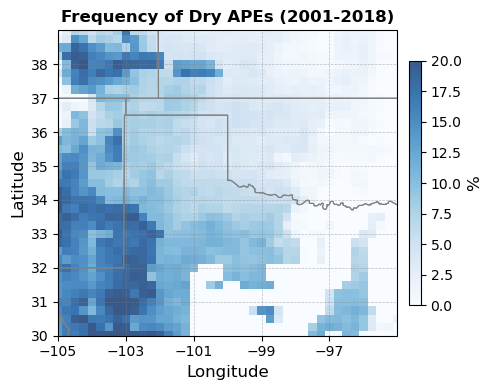

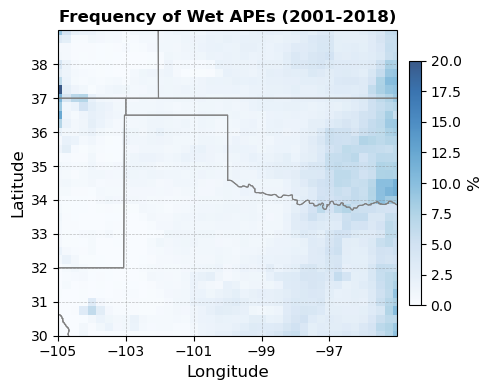

In [20]:
from matplotlib.patches import Rectangle

latitudes = np.sort(master['latitude'].unique())

longitudes = np.sort(master['longitude'].unique())

dfs = [(dry_counts, 'Frequency of Dry APEs (2001-2018)'), 
       
       (wet_counts, 'Frequency of Wet APEs (2001-2018)')]

cmap = plt.get_cmap('Blues')

cmap.set_under('white')

for df, title in dfs:

    true_proportions_grid = np.full((len(latitudes), len(longitudes)), np.nan)

    for idx, row in df.iterrows():
        
        lat_idx = np.where(latitudes == row['latitude'])[0][0]
        
        lon_idx = np.where(longitudes == row['longitude'])[0][0]
        
        true_proportions_grid[lat_idx, lon_idx] = row['normalized']

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})

    ax.set_extent([longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()])
    
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1.2)
    
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=1)
    
    ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.8, edgecolor='gray')

    # Plot the heatmap with fixed colorbar range
    c = ax.pcolormesh(longitudes, latitudes, true_proportions_grid, 
                      cmap=cmap, shading='auto', alpha=0.8, vmin=0, vmax=20)

    # Add a color bar with a fixed range (0-25)
    cbar = fig.colorbar(c, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)
    
    cbar.set_label('%', fontsize=12)

    # Set dynamic title
    ax.set_title(title, fontsize=12, fontweight='bold')

    # Set latitude and longitude ticks
    ax.set_xticks(np.arange(longitudes.min(), longitudes.max(), step=2))
    
    ax.set_yticks(np.arange(latitudes.min(), latitudes.max(), step=1))

    # Label the axes
    ax.set_xlabel('Longitude', fontsize=12)
    
    ax.set_ylabel('Latitude', fontsize=12)

    # Add gridlines
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

    plt.tight_layout()
    
    plt.show()


### grouping by gridpoint

In [21]:
# z score statistics 

apes_z_grouped = apes.groupby(["latitude", "longitude"], as_index=False)[['blc_stnd_anom', 'blt_stnd_anom']].mean()

non_apes_z_grouped = nonapes.groupby(["latitude", "longitude"], as_index=False)[['blc_stnd_anom', 'blt_stnd_anom']].mean()

dry_apes_z_grouped = dryapes.groupby(["latitude", "longitude"], as_index=False)[['blc_stnd_anom', 'blt_stnd_anom']].mean()

wet_apes_z_grouped = wetapes.groupby(["latitude", "longitude"], as_index=False)[['blc_stnd_anom', 'blt_stnd_anom']].mean()

# raw blc and blt values

apes_grouped = apes.groupby(["latitude", "longitude"], as_index=False)[['blc', 'blt']].mean()

non_apes_grouped = nonapes.groupby(["latitude", "longitude"], as_index=False)[['blc', 'blt']].mean()

# difference: dry apes minus wet apes 

dry_minus_wet = dry_apes_z_grouped[['latitude', 'longitude', 'blc_stnd_anom', 'blt_stnd_anom']].copy()

dry_minus_wet['blc_stnd_anom'] = dry_apes_z_grouped['blc_stnd_anom'] - wet_apes_z_grouped['blc_stnd_anom']

dry_minus_wet['blt_stnd_anom'] = dry_apes_z_grouped['blt_stnd_anom'] - wet_apes_z_grouped['blt_stnd_anom']

# difference: apes - nonapes raw blc and blt values

apes_minus_nonapes = apes_grouped[['latitude', 'longitude', 'blc', 'blt']].copy()

apes_minus_nonapes['blc'] = apes_grouped['blc'] - non_apes_grouped['blc']

apes_minus_nonapes['blt'] = apes_grouped['blt'] - non_apes_grouped['blt']

### Joint frequency distributions for mean grid-point blt and blc anomalies for wet and dry apes

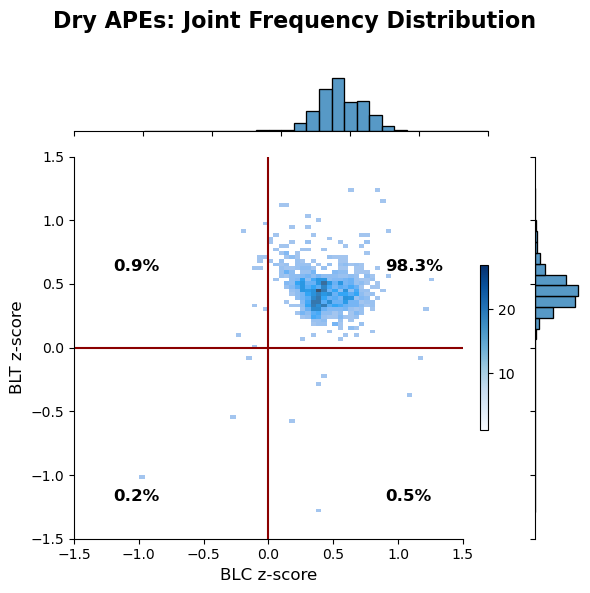

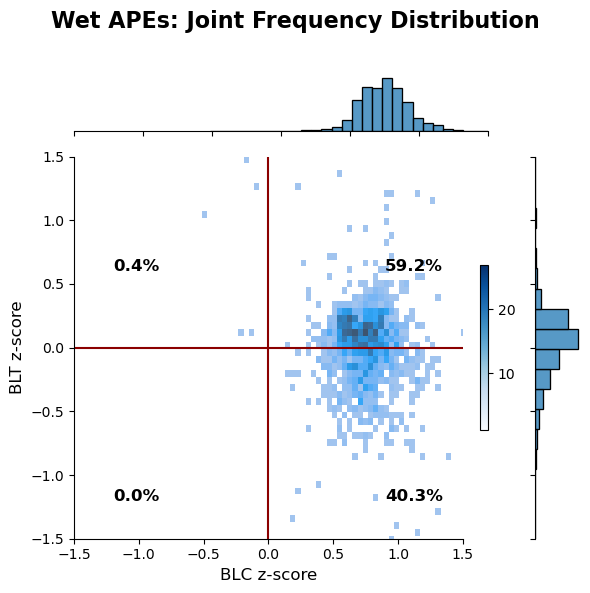

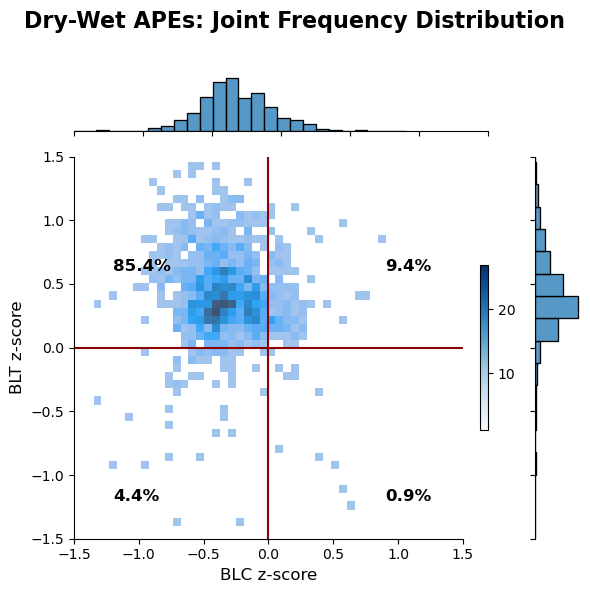

In [22]:
warnings.simplefilter(action='ignore', category=FutureWarning)

df_dry_clean = dry_apes_z_grouped.dropna(subset=["blt_stnd_anom", "blc_stnd_anom"])

df_wet_clean = wet_apes_z_grouped.dropna(subset=["blt_stnd_anom", "blc_stnd_anom"])

diff_clean = dry_minus_wet.dropna(subset=["blt_stnd_anom", "blc_stnd_anom"])

def annotate_quadrants(g, df):
    total = len(df)
    
    # With x = "blc_stnd_anom" and y = "blt_stnd_anom", the quadrants become:
    q1 = len(df[(df["blt_stnd_anom"] > 0) & (df["blc_stnd_anom"] > 0)])  # Top-right
    q2 = len(df[(df["blt_stnd_anom"] > 0) & (df["blc_stnd_anom"] < 0)])  # Top-left
    q3 = len(df[(df["blt_stnd_anom"] < 0) & (df["blc_stnd_anom"] < 0)])  # Bottom-left
    q4 = len(df[(df["blt_stnd_anom"] < 0) & (df["blc_stnd_anom"] > 0)])  # Bottom-right

    # Convert counts to percentages
    p1, p2, p3, p4 = (q1 / total) * 100, (q2 / total) * 100, (q3 / total) * 100, (q4 / total) * 100

    # Annotate on the plot using axes coordinates:
    g.ax_joint.text(0.8, 0.7, f"{p1:.1f}%", transform=g.ax_joint.transAxes, fontsize=12, 
                    color="black", weight='bold')
    g.ax_joint.text(0.1, 0.7, f"{p2:.1f}%", transform=g.ax_joint.transAxes, fontsize=12, 
                    color="black", weight='bold')
    g.ax_joint.text(0.1, 0.1, f"{p3:.1f}%", transform=g.ax_joint.transAxes, fontsize=12, 
                    color="black", weight='bold')
    g.ax_joint.text(0.8, 0.1, f"{p4:.1f}%", transform=g.ax_joint.transAxes, fontsize=12, 
                    color="black", weight='bold')
lim = 1.5

# --- Dry Apes Plot ---
g1 = sns.jointplot(
    data=df_dry_clean,
    x="blc_stnd_anom",
    y="blt_stnd_anom",
    kind="hist",
    marginal_kws=dict(bins=30, fill=True),
)
g1.ax_joint.set_xlim(-lim, lim)
g1.ax_joint.set_ylim(-lim, lim)

g1.ax_joint.axhline(0, color='darkred', linestyle='-', linewidth=1.5)
g1.ax_joint.axvline(0, color='darkred', linestyle='-', linewidth=1.5)

# Customize the title and labels
g1.fig.suptitle("Dry APEs: Joint Frequency Distribution", fontsize=16, fontweight='bold', ha='center', va='top')

g1.set_axis_labels("BLC z-score", "BLT z-score", fontsize=12)

# Add a color bar to the plot
# Create a color map
cmap = plt.cm.Blues  # Choose your color map (e.g., 'viridis', 'plasma', etc.)

norm = Normalize(vmin=g1.ax_joint.collections[0].get_array().min(), vmax=g1.ax_joint.collections[0].get_array().max())

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

sm.set_array([])

# Add the color bar on the right outside of the JFD plot
g1.fig.colorbar(sm, ax=g1.ax_joint, orientation='vertical', fraction=0.02, pad=0.04)

# Adjust layout and spacing
g1.fig.tight_layout(rect=[0, 0, 1, 0.96])  # To ensure title doesn't overlap

annotate_quadrants(g1, df_dry_clean)

plt.show()  # Show the first plot before moving to the next

# --- Wet Apes Plot ---
g2 = sns.jointplot(
    
    data=df_wet_clean,
    
    x="blc_stnd_anom",
    
    y="blt_stnd_anom",
    
    kind="hist",
    
    marginal_kws=dict(bins=30, fill=True),
)

g2.ax_joint.set_xlim(-lim, lim)

g2.ax_joint.set_ylim(-lim, lim)

g2.ax_joint.axhline(0, color='darkred', linestyle='-', linewidth=1.5)

g2.ax_joint.axvline(0, color='darkred', linestyle='-', linewidth=1.5)

# Customize the title and labels
g2.fig.suptitle("Wet APEs: Joint Frequency Distribution", fontsize=16, fontweight='bold', ha='center', va='top')

g2.set_axis_labels("BLC z-score", "BLT z-score", fontsize=12)

# Add a color bar to the plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

sm.set_array([])

g2.fig.colorbar(sm, ax=g2.ax_joint, orientation='vertical', fraction=0.02, pad=0.04)

# Adjust layout and spacing
g2.fig.tight_layout(rect=[0, 0, 1, 0.96])  # To ensure title doesn't overlap

annotate_quadrants(g2, df_wet_clean)

plt.show()  # Show the second plot

# --- Difference Dry-Minus-Wet Plot ---
g3 = sns.jointplot(
    data=diff_clean,
    x="blc_stnd_anom",
    y="blt_stnd_anom",
    kind="hist",
    marginal_kws=dict(bins=30, fill=True),
)
g3.ax_joint.set_xlim(-lim, lim)

g3.ax_joint.set_ylim(-lim, lim)

g3.ax_joint.axhline(0, color='darkred', linestyle='-', linewidth=1.5)

g3.ax_joint.axvline(0, color='darkred', linestyle='-', linewidth=1.5)

# Customize the title and labels
g3.fig.suptitle("Dry-Wet APEs: Joint Frequency Distribution", fontsize=16, fontweight='bold', ha='center', va='top')

g3.set_axis_labels("BLC z-score", "BLT z-score", fontsize=12)

# Add a color bar to the plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

sm.set_array([])

g3.fig.colorbar(sm, ax=g3.ax_joint, orientation='vertical', fraction=0.02, pad=0.04)

g3.fig.tight_layout(rect=[0, 0, 1, 0.96])

annotate_quadrants(g3, diff_clean)

plt.show()  # Show the third plot


### how does precipitation rate depend on BLT amount for dry vs. wet apes?

In [23]:
dryapes["afternoon_precip"] = dryapes["daily_precip"].apply(
    
    lambda x: sum(x[14:21]) if isinstance(x, (list, np.ndarray)) else np.nan
)

custom_blt_boundaries = [
    
    dryapes["blt_stnd_anom"].min(),
    
    dryapes["blt_stnd_anom"].quantile(1/5),
    
    dryapes["blt_stnd_anom"].quantile(2/5),
    
    dryapes["blt_stnd_anom"].quantile(3/5),
    
    dryapes["blt_stnd_anom"].quantile(4/5),
    
    dryapes["blt_stnd_anom"].max()
]

custom_blc_boundaries = [
    
    dryapes["blc_stnd_anom"].min(),
    
    dryapes["blc_stnd_anom"].quantile(1/5),
    
    dryapes["blc_stnd_anom"].quantile(2/5),
    
    dryapes["blc_stnd_anom"].quantile(3/5),
    
    dryapes["blc_stnd_anom"].quantile(4/5),
    
    dryapes["blc_stnd_anom"].max()
]


dryapes['blt_percentile'] = pd.cut(dryapes['blt_stnd_anom'], bins=custom_blt_boundaries, labels=[0.1, 0.3, 0.5, 0.7, 0.9], include_lowest=True)

dryapes['blc_percentile'] = pd.cut(dryapes['blc_stnd_anom'], bins=custom_blt_boundaries, labels=[0.1, 0.3, 0.5, 0.7, 0.9], include_lowest=True)


In [40]:
wetapes["afternoon_precip"] = wetapes["daily_precip"].apply(
    
    lambda x: sum(x[14:21]) if isinstance(x, (list, np.ndarray)) else np.nan
)

custom_blt_boundaries = [
    
    wetapes["blt_stnd_anom"].min(),
    
    wetapes["blt_stnd_anom"].quantile(1/5),
    
    wetapes["blt_stnd_anom"].quantile(2/5),
    
    wetapes["blt_stnd_anom"].quantile(3/5),
    
    wetapes["blt_stnd_anom"].quantile(4/5),
    
    wetapes["blt_stnd_anom"].max()
]

custom_blc_boundaries = [
    
    wetapes["blc_stnd_anom"].min(),
    
    wetapes["blc_stnd_anom"].quantile(1/5),
    
    wetapes["blc_stnd_anom"].quantile(2/5),
    
    wetapes["blc_stnd_anom"].quantile(3/5),
    
    wetapes["blc_stnd_anom"].quantile(4/5),
    
    wetapes["blc_stnd_anom"].max()
]

wetapes['blt_percentile'] = pd.cut(wetapes['blt_stnd_anom'], bins=custom_blt_boundaries, labels=[0.1, 0.3, 0.5, 0.7, 0.9], include_lowest=True)

wetapes['blc_percentile'] = pd.cut(wetapes['blc_stnd_anom'], bins=custom_blt_boundaries, labels=[0.1, 0.3, 0.5, 0.7, 0.9], include_lowest=True)


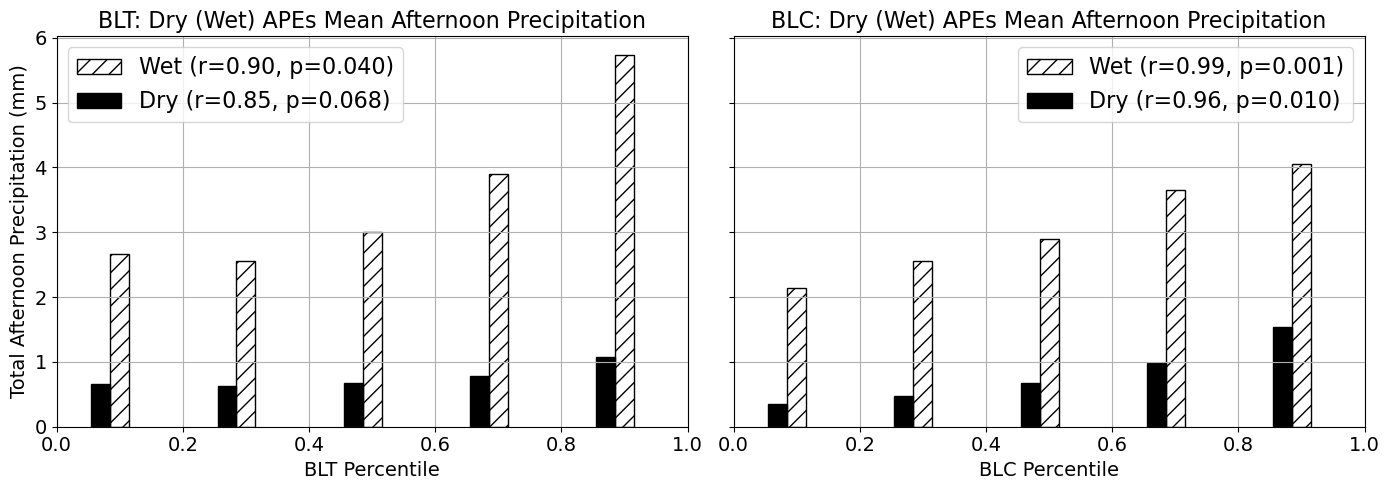

In [57]:
# Compute mean afternoon_precip for both percentiles
wet_apes_blt = pd.DataFrame(wetapes.groupby("blt_percentile")['afternoon_precip'].mean())

dry_apes_blt = pd.DataFrame(dryapes.groupby("blt_percentile")['afternoon_precip'].mean())

wet_apes_blc = pd.DataFrame(wetapes.groupby("blc_percentile")['afternoon_precip'].mean())

dry_apes_blc = pd.DataFrame(dryapes.groupby("blc_percentile")['afternoon_precip'].mean())

# Compute correlations

wet_corr_blt, wet_pval_blt = pearsonr(wet_apes_blt.index.astype(float), wet_apes_blt['afternoon_precip'])

dry_corr_blt, dry_pval_blt = pearsonr(dry_apes_blt.index.astype(float), dry_apes_blt['afternoon_precip'])

wet_corr_blc, wet_pval_blc = pearsonr(wet_apes_blc.index.astype(float), wet_apes_blc['afternoon_precip'])

dry_corr_blc, dry_pval_blc = pearsonr(dry_apes_blc.index.astype(float), dry_apes_blc['afternoon_precip'])

# X positions

dryx_positions_blt = np.array(dry_apes_blt.index).astype(float) - 0.03

wetx_positions_blt = np.array(wet_apes_blt.index).astype(float)

dryx_positions_blc = np.array(dry_apes_blc.index).astype(float) - 0.03

wetx_positions_blc = np.array(wet_apes_blc.index).astype(float)

# Create subplots

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Set font sizes

title_fontsize = 16

label_fontsize = 14

tick_fontsize = 14

# Plot for blt_percentile

axes[0].bar(wetx_positions_blt, wet_apes_blt['afternoon_precip'], width=0.03, edgecolor='black', 
            
            color='white', hatch='//', label=f'Wet (r={wet_corr_blt:.2f}, p={wet_pval_blt:.3f})')

axes[0].bar(dryx_positions_blt, dry_apes_blt['afternoon_precip'], width=0.03, edgecolor='black', 
            
            color='black', label=f'Dry (r={dry_corr_blt:.2f}, p={dry_pval_blt:.3f})')

axes[0].set_xticks([0, 1/5, 2/5, 3/5, 4/5, 1])

axes[0].tick_params(axis='both', labelsize=tick_fontsize)  # Increase tick label size

axes[0].set_xlabel("BLT Percentile", fontsize=label_fontsize)

axes[0].set_ylabel("Total Afternoon Precipitation (mm)", fontsize=label_fontsize)

axes[0].set_title("BLT: Dry (Wet) APEs Mean Afternoon Precipitation", fontsize=title_fontsize)

axes[0].legend()

axes[0].legend(fontsize=16)  

axes[0].grid()

# Plot for blc_percentile

axes[1].bar(wetx_positions_blc, wet_apes_blc['afternoon_precip'], width=0.03, edgecolor='black', 
            
            color='white', hatch='//', label=f'Wet (r={wet_corr_blc:.2f}, p={wet_pval_blc:.3f})')

axes[1].bar(dryx_positions_blc, dry_apes_blc['afternoon_precip'], width=0.03, edgecolor='black', 
            
            color='black', label=f'Dry (r={dry_corr_blc:.2f}, p={dry_pval_blc:.3f})') 

axes[1].set_xticks([0, 1/5, 2/5, 3/5, 4/5, 1])

axes[1].set_xlabel("BLC Percentile", fontsize=label_fontsize)

axes[1].set_title("BLC: Dry (Wet) APEs Mean Afternoon Precipitation", fontsize=title_fontsize)

axes[1].tick_params(axis='both', labelsize=tick_fontsize)  # Increase tick label size

axes[1].legend()

axes[1].legend(fontsize=16) 

axes[1].grid()

# Show plot

plt.tight_layout()

plt.show()



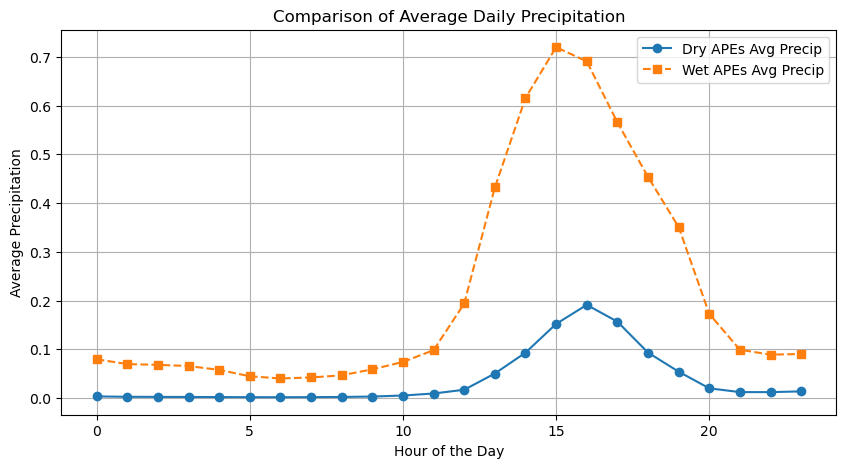

In [46]:
def average_precip(df):

    array_stack = np.vstack(df["daily_precip"].values)  # Stack all arrays
    
    return np.mean(array_stack, axis=0)  # Compute mean along the 0th axis (rows)

avg_precip_1 = average_precip(dryapes)

avg_precip_2 = average_precip(wetapes)

# Plot
plt.figure(figsize=(10, 5))

plt.plot(avg_precip_1, label="Dry APEs Avg Precip", marker="o", linestyle="-")

plt.plot(avg_precip_2, label="Wet APEs Avg Precip", marker="s", linestyle="--")

plt.xlabel("Hour of the Day")

plt.ylabel("Average Precipitation")

plt.title("Comparison of Average Daily Precipitation")

plt.legend()

plt.grid(True)

plt.show()

### apes vs. nonapes below

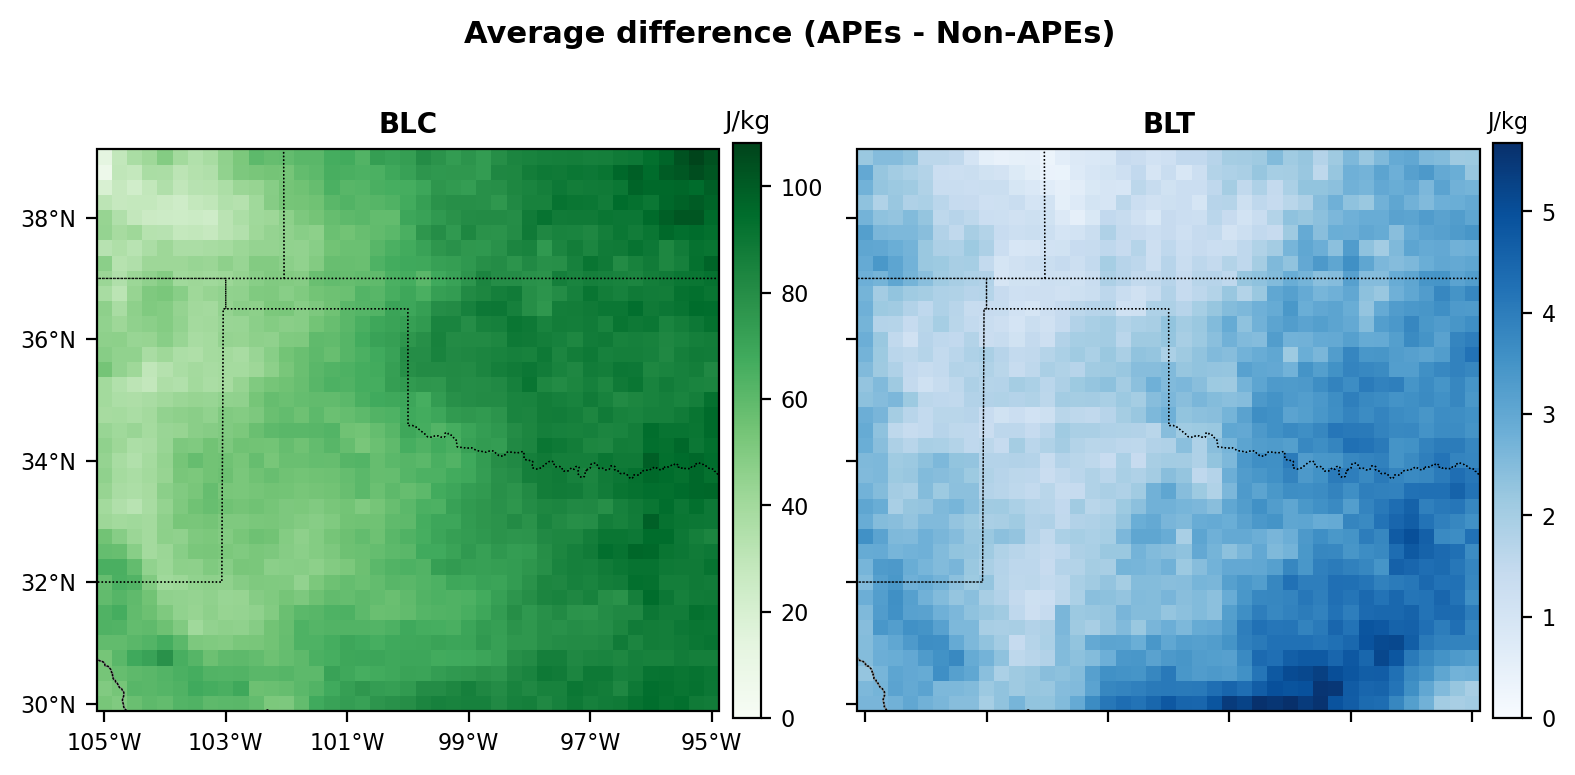

In [23]:
lats = np.sort(apes_minus_nonapes["latitude"].unique())

lons = np.sort(apes_minus_nonapes["longitude"].unique())

blc_grid = apes_minus_nonapes.pivot(index="latitude", columns="longitude", values="blc").values

blt_grid = apes_minus_nonapes.pivot(index="latitude", columns="longitude", values="blt").values

norm_blc = plt.Normalize(vmin=0, vmax=np.max(blc_grid))

norm_blt = plt.Normalize(vmin=0, vmax=np.max(blt_grid))

def plot_heatmap(ax, data, title, norm, cmap, label_ticks=True):
    
    mesh = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, shading="auto")
    
    ax.coastlines(linewidth=0.8)
    
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=0.6, edgecolor="gray")
    
    ax.add_feature(cfeature.STATES, linestyle=":", linewidth=0.5, edgecolor="black")
    
    ax.set_xticks(np.arange(np.min(lons), np.max(lons) + 1, 2), crs=ccrs.PlateCarree()) 
    
    ax.set_yticks(np.arange(np.min(lats), np.max(lats) + 1, 2), crs=ccrs.PlateCarree())

    # Reduce tick size
    ax.tick_params(axis="both", which="major", length=4, width=0.8, labelsize=8)
    
    ax.tick_params(axis="both", which="minor", length=2, width=0.5, labelsize=8)

    if label_ticks:
        
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        
        ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    else:
        
        ax.set_xticklabels([])
        
        ax.set_yticklabels([])

    ax.set_title(title, fontsize=10, fontweight="bold", pad=6)

    return mesh  
 

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200, subplot_kw={"projection": ccrs.PlateCarree()})

mesh1 = plot_heatmap(axes[0], blc_grid, "BLC", norm_blc, cmap='Greens', label_ticks=True)

mesh2 = plot_heatmap(axes[1], blt_grid, "BLT", norm_blt, cmap='Blues', label_ticks=False)

cbar1 = fig.colorbar(mesh1, ax=axes[0], orientation="vertical", fraction=0.05, pad=0.02, shrink=0.9)

cbar1.ax.tick_params(labelsize=8)

cbar1.ax.xaxis.set_label_position("top")

cbar1.ax.set_xlabel("J/kg", fontsize=9, labelpad=5)

cbar2 = fig.colorbar(mesh2, ax=axes[1], orientation="vertical", fraction=0.05, pad=0.02, shrink=0.9)

cbar2.ax.tick_params(labelsize=8)

cbar2.ax.xaxis.set_label_position("top")

cbar2.ax.set_xlabel("J/kg", fontsize=8, labelpad=5)

fig.suptitle("Average difference (APEs - Non-APEs)", fontsize=11, fontweight="bold", y=0.95)  

fig.tight_layout(rect=[0, 0, 1, 0.95])  

plt.show()


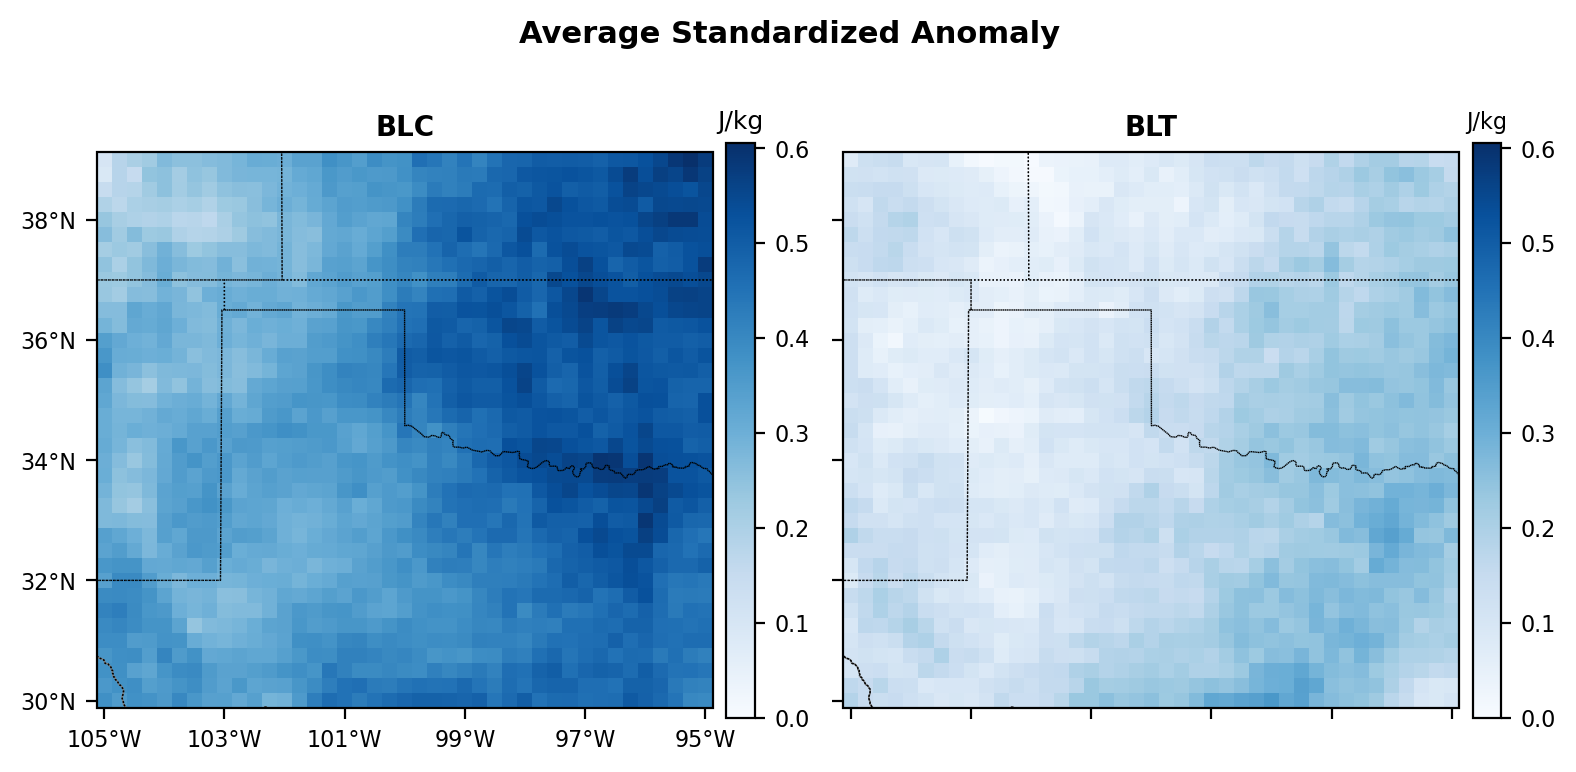

In [22]:
lats = np.sort(apes_stnd_anom_grouped["latitude"].unique())

lons = np.sort(apes_stnd_anom_grouped["longitude"].unique())

blc_grid = apes_stnd_anom_grouped.pivot(index="latitude", columns="longitude", values="blc_stnd_anom").values

blt_grid = apes_stnd_anom_grouped.pivot(index="latitude", columns="longitude", values="blt_stnd_anom").values

norm_blc = plt.Normalize(vmin=0, vmax=np.max(blc_grid))

norm_blt = plt.Normalize(vmin=0, vmax=np.max(blc_grid))

def plot_heatmap(ax, data, title, norm, cmap, label_ticks=True):
    
    mesh = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, shading="auto")
    
    ax.coastlines(linewidth=0.8)
    
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=0.6, edgecolor="gray")
    
    ax.add_feature(cfeature.STATES, linestyle=":", linewidth=0.5, edgecolor="black")
    
    ax.set_xticks(np.arange(np.min(lons), np.max(lons) + 1, 2), crs=ccrs.PlateCarree()) 
    
    ax.set_yticks(np.arange(np.min(lats), np.max(lats) + 1, 2), crs=ccrs.PlateCarree())

    # Reduce tick size
    
    ax.tick_params(axis="both", which="major", length=4, width=0.8, labelsize=8)
    
    ax.tick_params(axis="both", which="minor", length=2, width=0.5, labelsize=8)

    if label_ticks:
        
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        
        ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    else:
        
        ax.set_xticklabels([])
        
        ax.set_yticklabels([])

    ax.set_title(title, fontsize=10, fontweight="bold", pad=6)

    return mesh  
 

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200, subplot_kw={"projection": ccrs.PlateCarree()})

mesh1 = plot_heatmap(axes[0], blc_grid, "BLC", norm_blc, cmap='Blues', label_ticks=True)

mesh2 = plot_heatmap(axes[1], blt_grid, "BLT", norm_blt, cmap='Blues', label_ticks=False)

cbar1 = fig.colorbar(mesh1, ax=axes[0], orientation="vertical", fraction=0.05, pad=0.02, shrink=0.9)

cbar1.ax.tick_params(labelsize=8)

cbar1.ax.xaxis.set_label_position("top")

cbar1.ax.set_xlabel("J/kg", fontsize=9, labelpad=5)

cbar2 = fig.colorbar(mesh2, ax=axes[1], orientation="vertical", fraction=0.05, pad=0.02, shrink=0.9)

cbar2.ax.tick_params(labelsize=8)

cbar2.ax.xaxis.set_label_position("top")

cbar2.ax.set_xlabel("J/kg", fontsize=8, labelpad=5)

fig.suptitle("Average Standardized Anomaly", fontsize=11, fontweight="bold", y=0.95)  

fig.tight_layout(rect=[0, 0, 1, 0.95])  

plt.show()


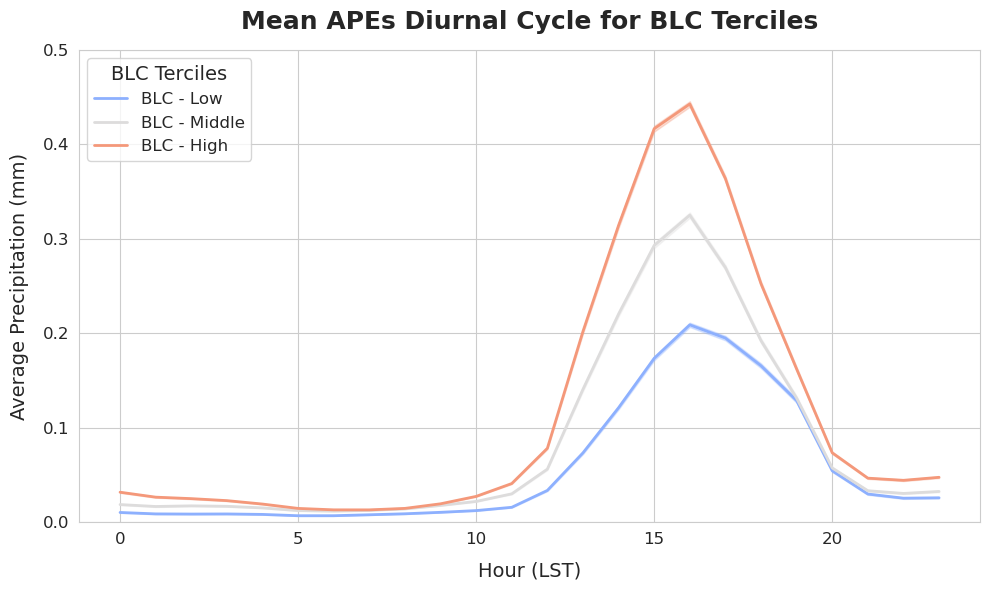

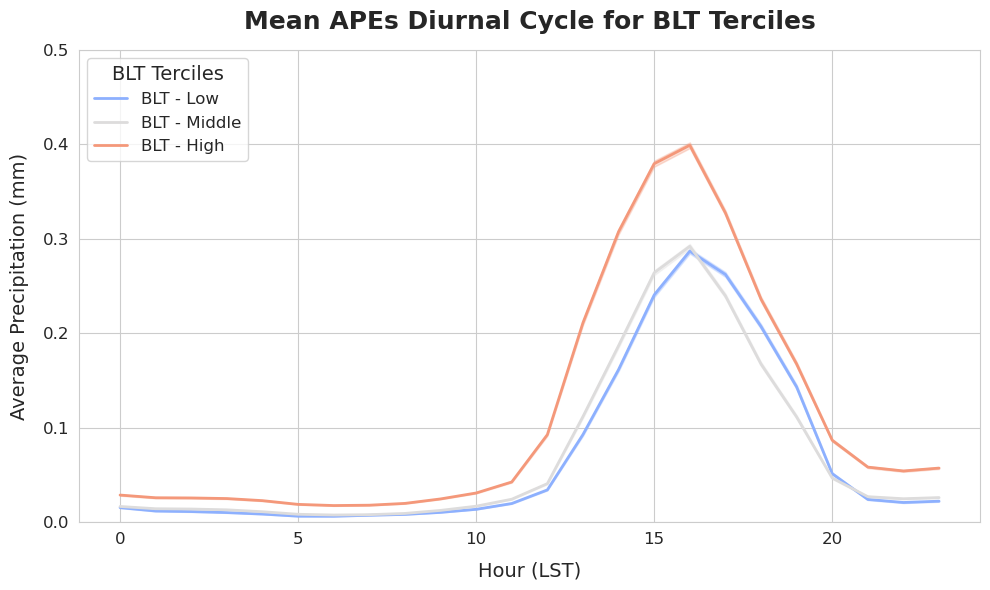

In [23]:
sns.set_style("whitegrid")

blc_terciles = np.percentile(apes['blc'].dropna(), [33, 66])

blt_terciles = np.percentile(apes['blt'].dropna(), [33, 66])

apes.loc[:, 'blc_tercile'] = np.digitize(apes['blc'], bins=[-np.inf, blc_terciles[0], blc_terciles[1], np.inf])

apes.loc[:, 'blt_tercile'] = np.digitize(apes['blt'], bins=[-np.inf, blt_terciles[0], blt_terciles[1], np.inf])

# Function to calculate mean and 95% confidence interval
def compute_ci(x):
    
    if len(x) > 1:  # Avoid division by zero
        
        mean = np.nanmean(np.array(x.tolist()), axis=0)
        
        std = np.nanstd(np.array(x.tolist()), axis=0)
        
        n = len(x)
        
        ci = 1.96 * (std / np.sqrt(n))  # 95% Confidence Interval
        
        return mean, ci
    
    else:
        
        return np.nan, np.nan

# Calculate average precipitation and confidence interval for each tercile
precip_stats_blc = apes.groupby('blc_tercile')['daily_precip'].apply(compute_ci)

precip_stats_blt = apes.groupby('blt_tercile')['daily_precip'].apply(compute_ci)

# Create labels for the terciles
tercile_labels = {1: 'Low', 2: 'Middle', 3: 'High'}

colors = sns.color_palette("coolwarm", 3)  # A cool-to-warm color palette with three colors

# Plotting for BLC
fig, ax = plt.subplots(figsize=(10, 6))

for tercile, (precip_avg, precip_ci) in precip_stats_blc.items():
    x_values = np.arange(len(precip_avg))  # Ensure correct x-axis indexing
    
    ax.fill_between(x_values, precip_avg - precip_ci, precip_avg + precip_ci, 
                    color=colors[tercile-1], alpha=0.3)
    
    ax.plot(x_values, precip_avg, label=f'BLC - {tercile_labels[tercile]}', 
            linewidth=2, color=colors[tercile-1])

ax.set_title('Mean APEs Diurnal Cycle for BLC Terciles', fontsize=18, fontweight='bold', pad=15)

ax.set_xlabel('Hour (LST)', fontsize=14, labelpad=10)

ax.set_ylabel('Average Precipitation (mm)', fontsize=14, labelpad=10)

ax.legend(title="BLC Terciles", fontsize=12, title_fontsize=14, loc='upper left', frameon=True)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.ylim(0, 0.5)

plt.tight_layout()

plt.show()

# Plotting for BLT
fig, ax = plt.subplots(figsize=(10, 6))

for tercile, (precip_avg, precip_ci) in precip_stats_blt.items():
    x_values = np.arange(len(precip_avg))  # Ensure correct x-axis indexing
    
    ax.fill_between(x_values, precip_avg - precip_ci, precip_avg + precip_ci, 
                    color=colors[tercile-1], alpha=0.3)
    
    ax.plot(x_values, precip_avg, label=f'BLT - {tercile_labels[tercile]}', 
            linewidth=2, color=colors[tercile-1])

ax.set_title('Mean APEs Diurnal Cycle for BLT Terciles', fontsize=18, fontweight='bold', pad=15)

ax.set_xlabel('Hour (LST)', fontsize=14, labelpad=10)

ax.set_ylabel('Average Precipitation (mm)', fontsize=14, labelpad=10)

ax.legend(title="BLT Terciles", fontsize=12, title_fontsize=14, loc='upper left', frameon=True)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.ylim(0, 0.5)

plt.tight_layout()

plt.show()


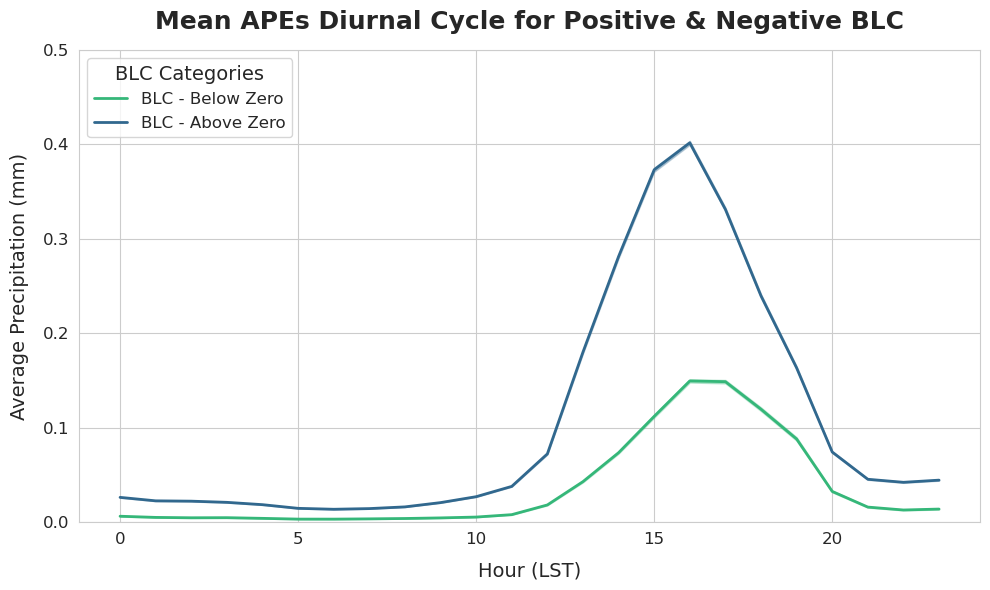

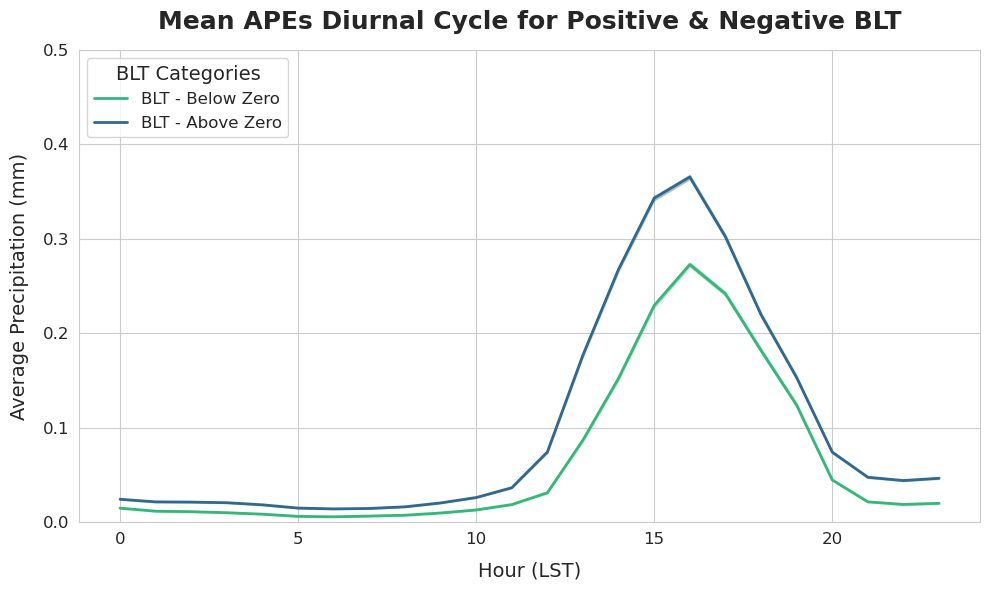

In [16]:
sns.set_style("whitegrid")

apes.loc[:, 'blc_category'] = np.where(apes['blc_stnd_anom'] > 0, 'Positive', 'Negative')

apes.loc[:, 'blt_category'] = np.where(apes['blt_stnd_anom'] > 0, 'Positive', 'Negative')

def compute_ci(x):
    
    if len(x) > 1:  # Avoid division by zero
        
        mean = np.nanmean(np.array(x.tolist()), axis=0)
        
        std = np.nanstd(np.array(x.tolist()), axis=0)
        
        n = len(x)
        
        ci = 1.96 * (std / np.sqrt(n))  # 95% Confidence Interval
        
        return mean, ci
    
    else:
        
        return np.nan, np.nan

# Calculate average precipitation and confidence interval for each category for 'blc' and 'blt'
precip_stats_blc = apes.groupby('blc_category')['daily_precip'].apply(compute_ci)

precip_stats_blt = apes.groupby('blt_category')['daily_precip'].apply(compute_ci)

# Category labels
category_labels = {'Positive': 'Above Zero', 'Negative': 'Below Zero'}

# Color palette for the categories
colors = sns.color_palette("viridis", 2)  # Distinct color mapping for two categories

# Plotting for BLC
fig, ax = plt.subplots(figsize=(10, 6))

for category, (precip_avg, precip_ci) in precip_stats_blc.items():
    
    x_values = np.arange(len(precip_avg))  # Ensure correct x-axis indexing
    
    ax.fill_between(x_values, precip_avg - precip_ci, precip_avg + precip_ci, 
                    color=colors[0] if category == 'Positive' else colors[1], alpha=0.3)
    ax.plot(x_values, precip_avg, label=f'BLC - {category_labels[category]}', 
            linewidth=2, color=colors[0] if category == 'Positive' else colors[1])

ax.set_title('Mean APEs Diurnal Cycle for Positive & Negative BLC', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Hour (LST)', fontsize=14, labelpad=10)
ax.set_ylabel('Average Precipitation (mm)', fontsize=14, labelpad=10)
ax.legend(title="BLC Categories", fontsize=12, title_fontsize=14, loc='upper left', frameon=True)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()

# Plotting for BLT
fig, ax = plt.subplots(figsize=(10, 6))

for category, (precip_avg, precip_ci) in precip_stats_blt.items():
    x_values = np.arange(len(precip_avg))  
    ax.fill_between(x_values, precip_avg - precip_ci, precip_avg + precip_ci, 
                    color=colors[0] if category == 'Positive' else colors[1], alpha=0.3)
    ax.plot(x_values, precip_avg, label=f'BLT - {category_labels[category]}', 
            linewidth=2, color=colors[0] if category == 'Positive' else colors[1])

ax.set_title('Mean APEs Diurnal Cycle for Positive & Negative BLT', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Hour (LST)', fontsize=14, labelpad=10)
ax.set_ylabel('Average Precipitation (mm)', fontsize=14, labelpad=10)
ax.legend(title="BLT Categories", fontsize=12, title_fontsize=14, loc='upper left', frameon=True)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()


In [101]:
# t-test for separation between blt and blc

# Ensure daily_precip is stored as a NumPy array
apes['daily_precip'] = apes['daily_precip'].apply(np.array)

# Separate data into groups based on blc_category
positive_group = apes[apes['blt_category'] == 'Positive']['daily_precip'].to_list()

negative_group = apes[apes['blt_category'] == 'Negative']['daily_precip'].to_list()

positive_group = np.vstack(positive_group)  # Shape (num_days, 24)

negative_group = np.vstack(negative_group)

t_stats, p_values = stats.ttest_ind(positive_group, negative_group, axis=0, nan_policy='omit')

t_test_results = pd.DataFrame({'hour': np.arange(24), 't_stat': t_stats, 'p_value': p_values})

## k means

/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


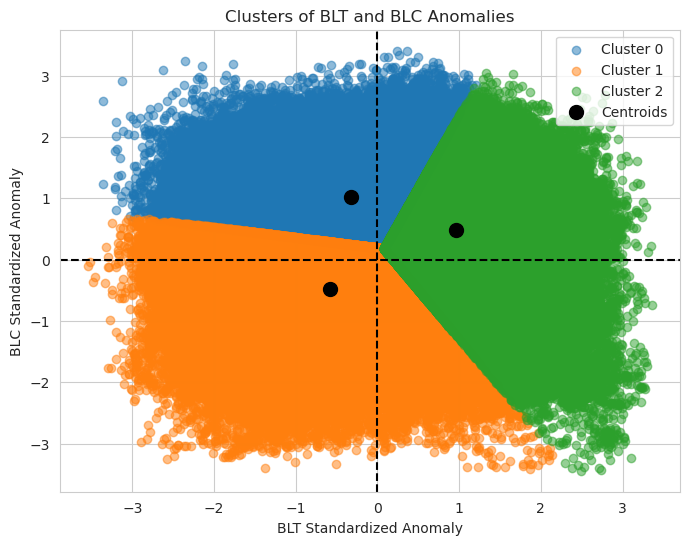

In [26]:
features = apes[['blt_stnd_anom', 'blc_stnd_anom']].dropna()

num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

clusters = kmeans.fit_predict(features)

apes.loc[apes.index.isin(features.index), 'cluster'] = clusters

plt.figure(figsize=(8, 6))

for i in range(num_clusters):
    
    plt.scatter(features.loc[clusters == i, 'blt_stnd_anom'],  
                
                features.loc[clusters == i, 'blc_stnd_anom'], 
                
                label=f'Cluster {i}', alpha=0.5)

plt.scatter(kmeans.cluster_centers_[:, 0], 
            
            kmeans.cluster_centers_[:, 1], 
            
            color='black', marker='o', s=100, label='Centroids')

plt.axvline(0, color='black', linestyle='--')

plt.axhline(0, color='black', linestyle='--')

plt.xlabel('BLT Standardized Anomaly')

plt.ylabel('BLC Standardized Anomaly')

plt.title('Clusters of BLT and BLC Anomalies')

plt.legend()

plt.grid(True)

plt.show()

In [20]:
# sil_score = silhouette_score(features, clusters)

# print(f'Silhouette Score: {sil_score:.3f}')

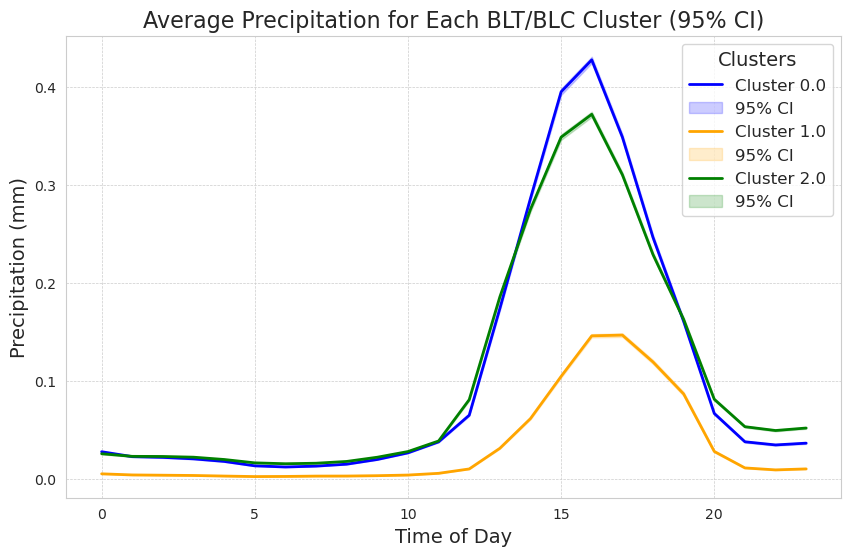

In [27]:
confidence_level = 0.95  # 95% Confidence Interval

precip_stats = apes.groupby('cluster')['daily_precip'].apply(
    
    lambda x: (
        
        np.nanmean(np.array(x.tolist()), axis=0),  # Mean precipitation
        
        stats.t.ppf((1 + confidence_level) / 2, df=np.sum(~np.isnan(np.array(x.tolist())), axis=0) - 1) * 
        
        np.nanstd(np.array(x.tolist()), axis=0) / np.sqrt(np.sum(~np.isnan(np.array(x.tolist())), axis=0))  # 95% CI
    )
)

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'orange', 'green']  

for i, (cluster, (precip_avg, precip_ci)) in enumerate(precip_stats.items()):
    ax.plot(precip_avg, label=f'Cluster {cluster}', linewidth=2, color=colors[i])
    
    ax.fill_between(range(len(precip_avg)), 
                    precip_avg - precip_ci, 
                    precip_avg + precip_ci, 
                    color=colors[i], alpha=0.2, label="95% CI")

ax.set_title('Average Precipitation for Each BLT/BLC Cluster (95% CI)', fontsize=16)

ax.set_xlabel('Time of Day', fontsize=14)

ax.set_ylabel('Precipitation (mm)', fontsize=14)

ax.legend(title="Clusters", fontsize=12, title_fontsize=14)

ax.grid(True, linestyle='--', linewidth=0.5)

plt.show()


In [24]:
with open('master.pkl', 'wb') as f:
    
    pickle.dump(master, f)